In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

IndexError: list index out of range

In [ ]:
import numpy as np
import os
import re
import split_extract
import matplotlib.pyplot as plt
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from multiprocessing import Pool
from params import dresden_images_root, images_db_path, patch_span, \
        patch_num, robust_root, robust_db_path

In [ ]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('model.h5')

In [ ]:
images_db = np.load(images_db_path, allow_pickle=True).item()
real_model_list = list(filter(lambda model: re.search(r'Canon*', model), images_db['brand_model']))
test_model_list = list(filter(lambda model: re.search(r'^((?!Canon).)*$', model), images_db['brand_model']))
test_img_list = list(filter(lambda img: re.search(r'^((?!Canon).)*$', img), images_db['path']))

# How many model in my dataset
real_model = np.unique(real_model_list) 
test_model = np.unique(test_model_list) 

In [ ]:
test_model

In [ ]:
images_db = np.load(images_db_path, allow_pickle=True).item()

test_model_list = list(filter(lambda model: re.search(r'^((?!Canon).)*$', model), images_db['brand_model']))
test_img_list = list(filter(lambda img: re.search(r'^((?!Canon).)*$', img), images_db['path']))

# How many model in my dataset
model_list = np.unique(test_model_list) 
files_labels = dict(zip(test_img_list, test_model_list))

In [12]:
img_name = os.path.join(robust_images_root, 'test\Nikon_D70s')
patches = io.imread(img_name)

img_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
img_generator = img_gen.flow(np.expand_dims(patches, 3), batch_size=64)

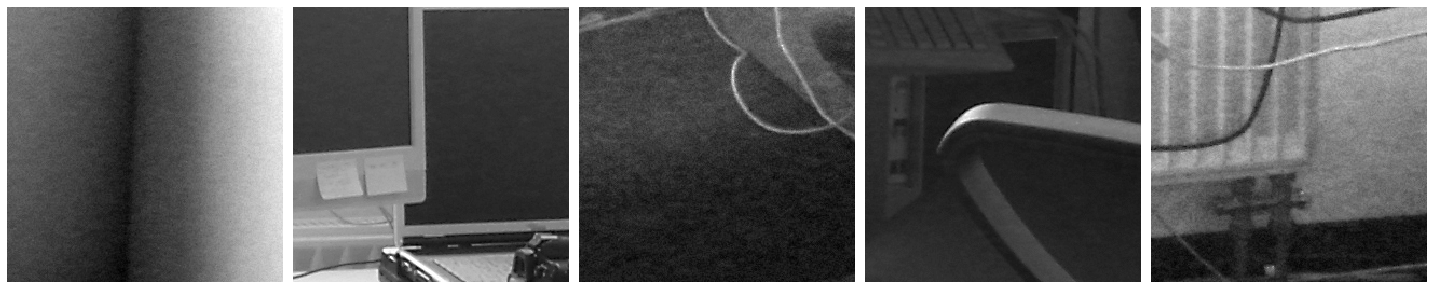

In [24]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:, :, 0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(next(img_generator)[:5])

In [25]:
hist = [0, 0, 0]
pred = model.predict(img_generator)

for i in range(patch_num):
    label = np.argmax(pred[i])
    hist[label] += 1
    
print(model_list)
print(img_brand_model)
print(hist)

['Agfa_DC-504' 'Agfa_DC-733s' 'Agfa_DC-830i' 'Agfa_Sensor505-x'
 'Agfa_Sensor530s']
Agfa_DC-830i
[0, 2, 23]


In [ ]:
# print('\n# Evaluate on test data')
# results = model.evaluate(test_generator)
# print('test loss, test acc:', results)